In [1]:
import os, re, pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from iEEG_helper_functions import *

In [2]:
SPIKES_OUTPUT_DIR = "../../Data/spikes/devin_spikes/"
SEIZURES_DIR = "../../Data/seizures/source_mat/"
IEEG_DIRECTORY = "../../Data/ieeg/all/2_min"
SEIZURE_BUFFER_TIME = 5  # hours

In [3]:
patient_hup_id = 210
fs = 1024
# Calculate the buffer time in samples
buffer_samples = SEIZURE_BUFFER_TIME * 3600 * fs

In [4]:
# Initialize an empty list to hold the data
data = []

# Iterate through all files in the directory
for filename in os.listdir(SPIKES_OUTPUT_DIR):
    # Check if the file ends with .npy
    if filename.endswith(".npy"):
        # Use regular expression to match the pattern and extract desired numbers
        match = re.match(r"HUP(\d+)_phaseII_(\d+).npy", filename)

        if match:
            current_patient_hup_id = int(match.group(1))
            if current_patient_hup_id != patient_hup_id:
                continue
            interval_index = int(match.group(2))

            # Append the data to the list
            data.append(
                {
                    "filename": filename,
                    "interval_index": interval_index,
                }
            )

# Convert the list of dictionaries to a pandas DataFrame
spike_files_df = pd.DataFrame(data)
# Sort the DataFrame by the interval index
spike_files_df = spike_files_df.sort_values(by="interval_index")
# Reset the index
spike_files_df = spike_files_df.reset_index(drop=True)
# Add a new column called "start_sample_index"
spike_files_df["start_sample_index"] = spike_files_df["interval_index"] * fs * 60 * 2
spike_files_df

,filename,interval_index,start_sample_index
0,HUP210_phaseII_562.npy,562,69058560
1,HUP210_phaseII_576.npy,576,70778880
2,HUP210_phaseII_577.npy,577,70901760
3,HUP210_phaseII_586.npy,586,72007680
4,HUP210_phaseII_589.npy,589,72376320
...,...,...,...
7002,HUP210_phaseII_7766.npy,7766,954286080
7003,HUP210_phaseII_7767.npy,7767,954408960
7004,HUP210_phaseII_7768.npy,7768,954531840
7005,HUP210_phaseII_7769.npy,7769,954654720


In [5]:
# Initialize an empty list to store individual DataFrames
dfs = []

for index, row in spike_files_df.iterrows():
    filename = row["filename"]
    start_sample_index = row["start_sample_index"]

    # Load the data
    spike_data = np.load(os.path.join(SPIKES_OUTPUT_DIR, filename))

    # Convert all values to int
    spike_data = spike_data.astype(int)

    # Adjust the start_sample_index
    spike_data[:, 0] += start_sample_index

    # Convert the modified spike_data to a DataFrame and append to the dfs list
    dfs.append(
        pd.DataFrame(
            spike_data,
            columns=["peak_index_samples", "channel_index", "sequence_index"],
        )
    )

# Concatenate all the individual DataFrames into a single DataFrame
all_spikes_df = pd.concat(dfs, ignore_index=True)

all_spikes_df

,peak_index_samples,channel_index,sequence_index
0,69114386,40,0
1,69114427,0,0
2,69116031,40,1
3,69116031,39,1
4,70886208,0,0
...,...,...,...
650876,954776715,20,29
650877,954776717,21,29
650878,954776729,69,29
650879,954952677,0,0


In [6]:
filename = f"HUP{patient_hup_id}_phaseII_hr_66_fs_{fs}.pkl"
# Get the full path to the file
full_path = os.path.join(IEEG_DIRECTORY, filename)

with open(full_path, "rb") as f:
    ieeg_data = pickle.load(f)

all_channel_labels = ieeg_data.columns.values.astype(str)
label_idxs = electrode_selection(all_channel_labels)
labels = all_channel_labels[label_idxs]
good_channels_res = detect_bad_channels_optimized(ieeg_data[labels].to_numpy(), fs)
good_channel_indicies = good_channels_res[0]
good_labels = labels[good_channel_indicies]

In [7]:
soz_channel_labels = [
    "LA01",
    "LA02",
    "LA09",
    "LA10",
    "LB01",
    "LB02",
    "LB03",
    "LB04",
    "LB09",
    "LB10",
    "LB11",
    "LD01",
    "LD02",
    "LD03",
    "LD04",
    "LE010",
    "LE011",
    "LE012",
    "LE01",
    "LE02",
    "LF01",
    "LF02",
    "LG01",
    "LG02",
    "LG03",
    "LK01",
    "LK02",
    "LK03",
    "LK04",
    "LK05",
    "LK06",
    "LK07",
    "LK08",
    "LK09",
    "LM07",
    "LM08",
    "LM09",
    "LN01",
    "LN02",
    "LN03",
    "LN04",
    "LN05",
    "LN06",
    "LN07",
    "LN08",
    "LN09",
    "LN10",
    "LN11",
    "LN12",
]
soz_channel_labels = np.array(soz_channel_labels)

In [8]:
all_spikes_df["channel_label"] = all_spikes_df["channel_index"].map(
    lambda x: good_labels[x]
)
all_spikes_df["is_soz"] = all_spikes_df["channel_label"].isin(soz_channel_labels)

# Add a column called peak_time_microseconds
all_spikes_df["peak_time_microseconds"] = (
    all_spikes_df["peak_index_samples"] / fs * 1e6
).astype(int)

# Reorder the columns to be peak_index_samples, channel_index, channel_label, is_soz, sequence_index
all_spikes_df = all_spikes_df[
    [
        "peak_index_samples",
        "peak_time_microseconds",
        "channel_index",
        "channel_label",
        "is_soz",
        "sequence_index",
    ]
]

all_spikes_df

,peak_index_samples,peak_time_microseconds,channel_index,channel_label,is_soz,sequence_index
0,69114386,67494517578,40,LD01,True,0
1,69114427,67494557617,0,C03,False,0
2,69116031,67496124023,40,LD01,True,1
3,69116031,67496124023,39,LC11,False,1
4,70886208,69224812500,0,C03,False,0
...,...,...,...,...,...,...
650876,954776715,932399135742,20,LB04,True,29
650877,954776717,932399137695,21,LB05,False,29
650878,954776729,932399149414,69,LF07,False,29
650879,954952677,932570973632,0,C03,False,0


In [9]:
# Calculate the inter-spike interval
all_spikes_df.loc[:, "inter_spike_interval_samples"] = all_spikes_df[
    "peak_index_samples"
].diff()

# Convert the inter_spike_interval_samples column to integer
all_spikes_df.loc[:, "inter_spike_interval_samples"] = (
    all_spikes_df["inter_spike_interval_samples"].fillna(0).astype(int)
)

all_spikes_df

/tmp/ipykernel_54033/3720138829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_spikes_df.loc[:, "inter_spike_interval_samples"] = all_spikes_df[
/tmp/ipykernel_54033/3720138829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_spikes_df.loc[:, "inter_spike_interval_samples"] = (
/tmp/ipykernel_54033/3720138829.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use ei

,peak_index_samples,peak_time_microseconds,channel_index,channel_label,is_soz,sequence_index,inter_spike_interval_samples
0,69114386,67494517578,40,LD01,True,0,0
1,69114427,67494557617,0,C03,False,0,41
2,69116031,67496124023,40,LD01,True,1,1604
3,69116031,67496124023,39,LC11,False,1,0
4,70886208,69224812500,0,C03,False,0,1770177
...,...,...,...,...,...,...,...
650876,954776715,932399135742,20,LB04,True,29,0
650877,954776717,932399137695,21,LB05,False,29,2
650878,954776729,932399149414,69,LF07,False,29,12
650879,954952677,932570973632,0,C03,False,0,175948


In [10]:
threshold = np.exp(6)
threshold

403.4287934927351

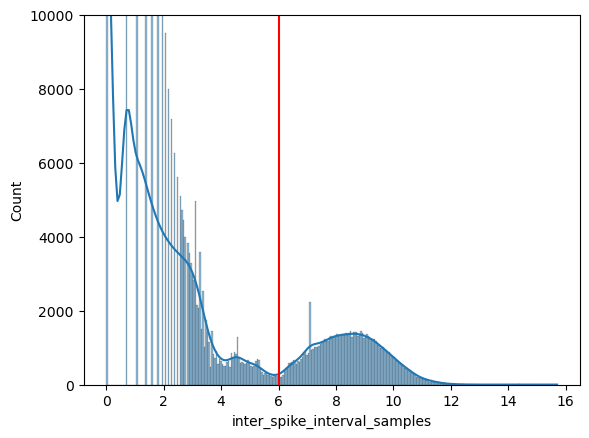

In [11]:
log_data = np.log(
    all_spikes_df[all_spikes_df["inter_spike_interval_samples"] > 0][
        "inter_spike_interval_samples"
    ]
)

sns.histplot(log_data, kde=True, bins=300)
# set y limit
plt.ylim(0, 10000)
# plot a vertical red line at x = threshold[0]
plt.axvline(x=np.log(threshold), color="red")

In [12]:
# Check for sequence change based on sequence_index or inter_spike_interval_samples
change_mask = (all_spikes_df["sequence_index"].diff() != 0) | (
    all_spikes_df["inter_spike_interval_samples"] > threshold
)

# Create the sequence_index_mask
all_spikes_df["sequence_index_mask"] = change_mask.astype(int).cumsum()

/tmp/ipykernel_54033/217808277.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_spikes_df["sequence_index_mask"] = change_mask.astype(int).cumsum()


In [13]:
all_spikes_df.head(50)

,peak_index_samples,peak_time_microseconds,channel_index,channel_label,is_soz,sequence_index,inter_spike_interval_samples,sequence_index_mask
0,69114386,67494517578,40,LD01,True,0,0,1
1,69114427,67494557617,0,C03,False,0,41,1
2,69116031,67496124023,40,LD01,True,1,1604,2
3,69116031,67496124023,39,LC11,False,1,0,2
4,70886208,69224812500,0,C03,False,0,1770177,3
5,70886214,69224818359,18,LB02,True,0,6,3
6,70886217,69224821289,16,LA12,False,0,3,3
7,70886222,69224826171,17,LB01,True,0,5,3
8,70893337,69231774414,10,LA06,False,1,7115,4
9,70893339,69231776367,6,LA02,True,1,2,4


In [14]:
# Drop the sequence_index column
all_spikes_df = all_spikes_df.drop(columns=["sequence_index"])
# Rename the sequence_index_mask column to sequence_index
all_spikes_df = all_spikes_df.rename(columns={"sequence_index_mask": "sequence_index"})
all_spikes_df

,peak_index_samples,peak_time_microseconds,channel_index,channel_label,is_soz,inter_spike_interval_samples,sequence_index
0,69114386,67494517578,40,LD01,True,0,1
1,69114427,67494557617,0,C03,False,41,1
2,69116031,67496124023,40,LD01,True,1604,2
3,69116031,67496124023,39,LC11,False,0,2
4,70886208,69224812500,0,C03,False,1770177,3
...,...,...,...,...,...,...,...
650876,954776715,932399135742,20,LB04,True,0,101041
650877,954776717,932399137695,21,LB05,False,2,101041
650878,954776729,932399149414,69,LF07,False,12,101041
650879,954952677,932570973632,0,C03,False,175948,101042


In [15]:
all_spikes_df.head(20)

,peak_index_samples,peak_time_microseconds,channel_index,channel_label,is_soz,inter_spike_interval_samples,sequence_index
0,69114386,67494517578,40,LD01,True,0,1
1,69114427,67494557617,0,C03,False,41,1
2,69116031,67496124023,40,LD01,True,1604,2
3,69116031,67496124023,39,LC11,False,0,2
4,70886208,69224812500,0,C03,False,1770177,3
5,70886214,69224818359,18,LB02,True,6,3
6,70886217,69224821289,16,LA12,False,3,3
7,70886222,69224826171,17,LB01,True,5,3
8,70893337,69231774414,10,LA06,False,7115,4
9,70893339,69231776367,6,LA02,True,2,4


In [16]:
# Adding is_leader column
all_spikes_df["is_leader"] = ~all_spikes_df["sequence_index"].duplicated(keep="first")
all_spikes_df

,peak_index_samples,peak_time_microseconds,channel_index,channel_label,is_soz,inter_spike_interval_samples,sequence_index,is_leader
0,69114386,67494517578,40,LD01,True,0,1,True
1,69114427,67494557617,0,C03,False,41,1,False
2,69116031,67496124023,40,LD01,True,1604,2,True
3,69116031,67496124023,39,LC11,False,0,2,False
4,70886208,69224812500,0,C03,False,1770177,3,True
...,...,...,...,...,...,...,...,...
650876,954776715,932399135742,20,LB04,True,0,101041,False
650877,954776717,932399137695,21,LB05,False,2,101041,False
650878,954776729,932399149414,69,LF07,False,12,101041,False
650879,954952677,932570973632,0,C03,False,175948,101042,True


In [17]:
# Save the DataFrame to an csv file
all_spikes_df.to_csv(f"../../Public/spikes/HUP_{patient_hup_id}.csv", index=False)